In [33]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

import nltk
from nltk import pos_tag
from sklearn import metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import time

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer




In [2]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.3.
The scikit-learn version is 0.18.1.


In [ ]:
# Lemmentize Helper Functions
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
       
# I morph stuff.
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

# I lematize stuff.
def lemmatize_parse(text):
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):
        if(not is_number(word)):
            lemmatize.append(wnl.lemmatize(word.lower(), pos=penn2morphy(tag)))
    return lemmatize

In [2]:
computer_technology_subclasses = ['comp.graphics',
                                  'comp.os.ms-windows.misc',
                                  'comp.sys.ibm.pc.hardware',
                                  'comp.sys.mac.hardware']

recreational_activity_subclasses = ['rec.autos',
                                    'rec.motorcycles',
                                    'rec.sport.baseball',
                                    'rec.sport.hockey']

categories = computer_technology_subclasses + recreational_activity_subclasses

In [3]:
train_dataset = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

test_dataset = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

# Load in training and test sets with/without footers (re-defining to prevent screwing up existing code)

# Remove headers and footers
train_dataset_rmv_headfoot = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))
test_dataset_rmv_headfoot = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

# Keep headers and footers
train_dataset_keep_headfoot = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42)
test_dataset_keep_headfoot = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42)

# Turn Multiclass into Binary

In [4]:
binary_train_target = train_dataset.target.copy()
binary_test_target = test_dataset.target.copy()
computer_class_indices = [0,1,2,3]
recreational_class_indices = [4,5,6,7]

computer_class_label = 0
recreational_class_label = 1

# Binarize computer-class labels
for i in computer_class_indices:
    binary_train_target[binary_train_target == i] = computer_class_label
    binary_test_target[binary_test_target == i] = computer_class_label

# Binarize recreational-class labels
for i in recreational_class_indices:
    binary_train_target[binary_train_target==i] = recreational_class_label
    binary_test_target[binary_test_target == i] = recreational_class_label
 
print("Sanity Check!\n")
print("Training Set")
print("Original train_dataset.target: " + str(train_dataset.target[0:20]))
print("Binarized train_dataset.target:" + str(binary_train_target[0:20]))
print("\nTest Set")
print("Original test_dataset.target:  " + str(test_dataset.target[0:20]))
print("Binarized test_dataset.target: " + str(binary_test_target[0:20]))

Sanity Check!

Training Set
Original train_dataset.target: [6 7 4 2 1 3 0 7 5 3 0 5 5 5 3 1 3 0 0 2]
Binarized train_dataset.target:[1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0]

Test Set
Original test_dataset.target:  [3 2 3 3 2 3 2 6 0 1 0 1 7 7 1 5 7 2 0 1]
Binarized test_dataset.target: [0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0]


In [10]:
# set lemmatize 


t1 = time.time()
print("Lemmatizing training set with removed headers/footers...")
train_dataset_lemmatized_rmv_headfoot = []
for item in train_dataset_rmv_headfoot.data:
    train_dataset_lemmatized_rmv_headfoot.append(' '.join(lemmatize_parse(item)))
print("Completed training set with removed head/foot in %f sec\n" %(time.time()-t1))

t1 = time.time()
print("Lemmatizing test set with removed headers/footers...")
test_dataset_lemmatized_rmv_headfoot = []
for item in test_dataset_rmv_headfoot.data:
    test_dataset_lemmatized_rmv_headfoot.append(' '.join(lemmatize_parse(item)))
print("Completed test set with removed head/foot in %f sec\n" %(time.time()-t1))

# t1 = time.time()
# print("Lemmatizing training set with kept headers/footers...")
# train_data_lemmatized_keep_headfoot = []
# for item in train_dataset_keep_headfoot.data:
#     train_data_lemmatized_keep_headfoot.append(' '.join(lemmatize_parse(item)))
# print("Completed training set with kept head/foot in %f sec\n" %(time.time()-t1))

# t1 = time.time()
# print("Lemmatizing test set with kept headers/footers...")
# test_dataset_lemmatized_keep_headfoot = []
# for item in test_dataset_keep_headfoot.data:
#     test_dataset_lemmatized_keep_headfoot.append(' '.join(lemmatize_parse(item)))
        
train_dataset.data = train_dataset_lemmatized_rmv_headfoot
test_dataset.data = test_dataset_lemmatized_rmv_headfoot
print("Completed test set with kept head/foot in %f sec\n" %(time.time()-t1))

Lemmatizing training set with removed headers/footers...
Completed training set with removed head/foot in 81.698150 sec

Lemmatizing test set with removed headers/footers...
Completed test set with removed head/foot in 45.678211 sec

Completed test set with kept head/foot in 45.683783 sec



In [17]:
# vectorize - fit and transform
vectorizer = TfidfVectorizer(min_df=3, stop_words='english', use_idf=True)
X_train_tfidf = vectorizer.fit_transform(train_dataset.data)
X_test_tfidf = vectorizer.transform(test_dataset.data)

In [ ]:
#QUESTION 1: Report the dimensions of the TF-IDF matrix you get.

In [18]:
print('X_train_tfidf:',X_train_tfidf.shape)
print('X_test_tfidf:', X_test_tfidf.shape)

X_train_tfidf: (4732, 14416)
X_test_tfidf: (3150, 14416)


In [19]:
# K means
km = KMeans(n_clusters = 2)
km.fit(X_train_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
# transform confusion matrix to diagonal as much as possible (only for 2 * 2 sized confusion)
def to_diagonal(confusion):
    maxColIndices = []
    copy = []
    for row in range(len(confusion)):
        curRow = confusion[row]
        index = 0
        value = curRow[0]
        ro = []
        for col in range(len(curRow)):
            ro.append(curRow[col])
            if curRow[col] > value:
                index = col
                value = curRow[col]
        maxColIndices.append(index)
        copy.append(ro)
    res = []
    for i in range(len(confusion)):
        res.insert(maxColIndices[i], copy[i])
    res = np.array(res)
    return res



In [30]:
# contingency table (confusion matrix)
actual_class_names = ['Class 1', 'Class 2']
cluster_class_names = ['Cluster 1', 'Cluster 2']
def plot_contingency_table(cm, title='Contingency table', cmap=plt.cm.YlOrBr):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)

In [ ]:
#QUESTION 2: Report the contingency table of your clustering result.

In [ ]:
#QUESTION 3: Report the 5 measures above for the K-means clustering results you get.

contingency table:
[[2338   51]
 [ 384 1959]]


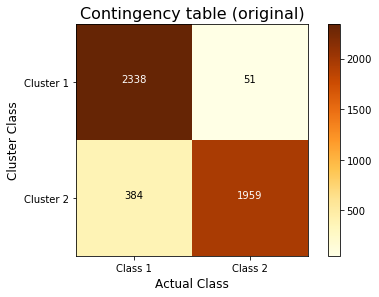

Homogeneity: 0.589809143768
Completeness: 0.599598316483
V-measure: 0.594663446242
Adjusted Rand Score: 0.666023599644
Adjusted Mutual Info Score: 0.589746579899


In [31]:
# Print results
confusion = metrics.confusion_matrix(binary_train_target, km.labels_)
contingency = to_diagonal(confusion)

print ('contingency table:')
print (contingency)
# Plot non-normalized contingency table
plt.figure()
title = 'Contingency table (original)'
plot_contingency_table(contingency, title=title)
plt.show()
print ('Homogeneity:', metrics.homogeneity_score(binary_train_target, km.labels_))
print ('Completeness:', metrics.completeness_score(binary_train_target, km.labels_))
print ('V-measure:', metrics.v_measure_score(binary_train_target, km.labels_))
print ('Adjusted Rand Score:', metrics.adjusted_rand_score(binary_train_target, km.labels_))
print ('Adjusted Mutual Info Score:', metrics.adjusted_mutual_info_score(binary_train_target, km.labels_))

In [ ]:
# QUESTION 4: Report the plot of the percent of variance the top r principle compo-
# nents can retain v.s. r, for r = 1 to 1000.

In [34]:
# calculate singular values
svd = TruncatedSVD(n_components = X_train_tfidf.shape[1] - 1, n_iter = 10, random_state = 42)
lsi_res = svd.fit_transform(X_train_tfidf)

singular_values = svd.singular_values_
sin_val_square = [x*x for x in singular_values]
original_variance = np.sum(sin_val_square)
prefix = []
percent = []
prefix.append(sin_val_square[0])
percent.append(prefix[0] / original_variance)
for terms in range(1, 1000, 1):
    prefix.append(prefix[terms - 1] + sin_val_square[terms])
    percent.append(prefix[terms] / original_variance)

# calculate percent of variance v.s. r
x_axis = [x for x in range(1, 1001, 1)]
plt.figure(figsize=(12,9))
plt.xlabel('Number of Principal Components r', fontsize = 18)
plt.ylabel('Percent of Variance Retained', fontsize = 18)
plt.title('Percent of Variance Retained (r = 1 to 1000)', fontsize = 23)
plt.xlim([0.0, 1010])
plt.ylim([0.0, 0.6])
plt.plot(x_axis, percent)
plt.show()

AttributeError: 'TruncatedSVD' object has no attribute 'singular_values_'

In [39]:
svd.singular_values_

AttributeError: 'TruncatedSVD' object has no attribute 'singular_values_'

In [ ]:
# QUESTION 5:
# Let r be the dimension that we want to reduce the data to (i.e. n components).
# Try r = 1; 2; 3; 5; 10; 20; 50; 100; 300, and plot the 5 measure scores v.s. r for both
# SVD and NMF.
# Report the best r choice for SVD and NMF respectively.
# Note: what is \best" after all? What if some measures contradict with each other? Here you are faced with this
# challenge that you need to decide which measure you value the most, and design your own standard of \best".
# Please explain your standard and justify it.

In [ ]:
# QUESTION 6: How do you explain the non-monotonic behavior of the measures as r
# increases?

In [ ]:
# QUESTION 7: Visualize the clustering results for:
#  SVD with its best r
#  NMF with its best r

In [ ]:
# QUESTION 8: Visualize the transformed data as in part (a).

In [ ]:
# QUESTION 9: Can you justify why the \logarithm transformation" may improve the
# clustering results?

In [ ]:
# QUESTION 10: Report the new clustering measures (except for the contingency ma-
# trix) for the clustering results of the transformed data.

In [ ]:
# QUESTION 11: Repeat the following for 20 categories using the same parameters as in
# 2-class case:
#  Transform corpus to TF-IDF matrix;
#  Directly perform K-means and report the 5 measures and the contingency matrix;

In [ ]:
# QUESTION 12: Try dierent dimensions for both truncated SVD and NMF dimensional-
# ity reduction techniques and the dierent transformations of the obtained feature vectors as
# outlined in above parts.
# You don't need to report everything you tried, which will be tediously long. You are asked,
# however, to report your best combination, and quantitatively report how much better
# it is compared to other combinations. You should also include typical combinations
# showing what choices are desirable (or undesirable).